# Gait generation

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{X} = \begin{bmatrix}
    x & y & z & \dot{x} &\dot{y} &\dot{z} 
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
    \textbf{u} = \begin{bmatrix}
    x_z & y_z & F_z
    \end{bmatrix}^T
\end{equation*}
$$


The dynamic equation for the system will be 

$$
\begin{equation*}
    \begin{bmatrix}
    \dot{X}  
    \end{bmatrix} 
    =
    \begin{bmatrix}
    \dot{x} \\ 
    \dot{y} \\ 
    \dot{z} \\ 
    \frac{(x-x_z)F_z}{mz} \\ 
    \frac{(y-y_z)F_z}{mz} \\ 
    \frac{F_z}{m}-g
    \end{bmatrix}
\end{equation*}
$$


where $\textbf{m}$ and $\textbf{g}$ are mass and the acceleration of gravity. In the following case, I will set $\textbf{m}$ to be 1.






In [791]:
%matplotlib inline

In [792]:
from __future__ import print_function

In [793]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt

In [832]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.dynamics import tensor_constrain
from ilqr.dynamics import constrain
from ilqr.dynamics import AutoDiffDynamics

In [802]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    print("iteration", iteration_count, info, J_opt)

In [836]:
x_inputs = [
    T.dscalar("x"),
    T.dscalar("y"),
    T.dscalar("z"),
    T.dscalar("x_dot"),
    T.dscalar("y_dot"),
    T.dscalar("z_dot"),
]

x_inputs_dot=[
    T.dscalar("xrk"),
    T.dscalar("yrk"),
    T.dscalar("zrk"),
    T.dscalar("x_dotrk"),
    T.dscalar("y_dotrk"),
    T.dscalar("z_dotrk"),
]

u_inputs = [
    T.dscalar("x_zmp"),
    T.dscalar("y_zmp"),
    T.dscalar("F_z"),
]


t = T.dscalar("t")

#min_bounds = np.array([0.0, 0.0, 0.0])
#max_bounds = np.array([300.0, 50.0, 100])
#u_constrained_inputs = tensor_constrain(u_inputs, min_bounds, max_bounds)



dt = 0.1  # Discrete time step.
g = 9.81  # g.





#nonlinear dynamics.
def nonldyn(x_inputs, u_inputs):
    x_inputs_dot[0]=x_inputs[3],
    x_inputs_dot[1]=x_inputs[4],
    x_inputs_dot[2]=x_inputs[5],
    x_inputs_dot[3]=(x_inputs[0]-u_inputs[0])*u_inputs[2]/x_inputs[2],
    x_inputs_dot[4]=(x_inputs[1]-u_inputs[1])*u_inputs[2]/x_inputs[2],
    x_inputs_dot[5]=u_inputs[2]-g,
    #return x_inputs_dot
    return T.stack([
        x_inputs_dot[0],
        x_inputs_dot[1],
        x_inputs_dot[2],
        x_inputs_dot[3],
        x_inputs_dot[4],
        x_inputs_dot[5],]

# discritize with RK4
# x_inputs_dot1=nonldyn(x_inputs,u_inputs)
# x_inputs_dot2=nonldyn(x_inputs+.5*dt*x_inputs_dot1,u_inputs)
# x_inputs_dot3=nonldyn(x_inputs+.5*dt*x_inputs_dot2,u_inputs)
# x_inputs_dot4=nonldyn(x_inputs+dt*x_inputs_dot3,u_inputs)

# discritize with RK4
# x_inputs_dot1=nonldyn(x_inputs,u_inputs)
# x_inputs_dot2=nonldyn(x_inputs+.5*dt*nonldyn(x_inputs,u_inputs),u_inputs)
# x_inputs_dot3=nonldyn(x_inputs+.5*dt*nonldyn(x_inputs+.5*dt*nonldyn(x_inputs,u_inputs),u_inputs),u_inputs)
# x_inputs_dot4=nonldyn(x_inputs+dt*nonldyn(x_inputs+.5*dt*nonldyn(x_inputs+.5*dt*nonldyn(x_inputs,u_inputs),u_inputs),u_inputs),u_inputs)

f = x_inputs+(dt/6)*(nonldyn(x_inputs,u_inputs)+2*nonldyn(x_inputs+.5*dt*nonldyn(x_inputs,u_inputs),u_inputs)+2*nonldyn(x_inputs+.5*dt*nonldyn(x_inputs+.5*dt*nonldyn(x_inputs,u_inputs),u_inputs),u_inputs)+nonldyn(x_inputs+dt*nonldyn(x_inputs+.5*dt*nonldyn(x_inputs+.5*dt*nonldyn(x_inputs,u_inputs),u_inputs),u_inputs))


'''
# Discrete dynamics model definition.
f = T.stack([
    x_inputs[0] + x_inputs[3] * dt,
    x_inputs[1] + x_inputs[4] * dt,
    x_inputs[2] + x_inputs[5] * dt,

    #x_inputs[3] + ((x_inputs[0]-u_constrained_inputs[0])*u_constrained_inputs[2]/x_inputs[2]) * dt,
    #x_inputs[4] + ((x_inputs[1]-u_constrained_inputs[1])*u_constrained_inputs[2]/x_inputs[2] )* dt,
    #x_inputs[5] + (u_constrained_inputs[2]-g) * dt,
      
    x_inputs[3] + ((x_inputs[0]-u_inputs[0])*u_inputs[2]/x_inputs[2]) * dt,
    x_inputs[4] + ((x_inputs[1]-u_inputs[1])*u_inputs[2]/x_inputs[2] )* dt,
    x_inputs[5] + (u_inputs[2]-g) * dt,])
'''

dynamics = AutoDiffDynamics(f, x_inputs, u_inputs,t)


SyntaxError: invalid syntax (<ipython-input-836-e7385bdc72c3>, line 70)

In [833]:
T = 100
state_size = 6
action_size = 3


'''
#try0: with 100 steps

xindex=[]
for i in range (1,102):
    xindex.append(i)
uindex=[]
for i in range (1,101):
    uindex.append(i)

Q = np.diag((10000,10000,20000,0.001,.001,.001))
R = np.diag((0.1,0.1,0.001))
a = np.array([10,13.626,16.897,20.551,25.318,31.351,37.813,43.768,48.33,51.378,53.388,54.85,56.258,58.103,60.877,65.072,70.774,77.131,83.161,87.906,91.1,93.2,94.699,96.089,97.861,100.51,104.52,110.09,116.42,122.54,127.46,130.81,133.01,134.55,135.92,137.63,140.16,143.99,149.42,155.71,161.9,167,170.5,172.8,174.39,175.76,177.41,179.82,183.49,188.75,195,201.25,206.51,210.18,212.59,214.24,215.61,217.2,219.5,223,228.1,234.29,240.58,246.01,249.84,252.37,254.08,255.45,256.99,259.19,262.54,267.46,273.58,279.91,285.48,289.49,292.14,293.91,295.3,296.8,298.9,302.09,306.84,312.87,319.23,324.93,329.12,331.9,333.74,335.15,336.61,338.62,341.67,346.23,352.19,358.65,364.68,369.45,373.1,376.37,5,5.1312,6.0498,8.5429,13.388,20.545,28.577,35.909,41.049,43.765,44.82,45,44.908,44.116,41.836,37.285,30.322,22.31,14.822,9.39,6.44,5.2396,5.0014,5.0617,5.7373,7.8125,12.075,18.823,26.797,34.421,40.14,43.333,44.689,44.995,44.961,44.392,42.512,38.531,32.016,24.1,16.36,10.362,6.9166,5.3955,5.0115,5.0225,5.4939,7.1901,10.898,17.162,25,32.838,39.102,42.81,44.506,44.977,44.988,44.605,43.083,39.638,33.64,25.9,17.984,11.469,7.4883,5.6075,5.0389,5.0049,5.311,6.667,9.86,15.579,23.203,31.177,37.925,42.187,44.263,44.938,44.999,44.76,43.56,40.61,35.178,27.69,19.678,12.715,8.1637,5.8843,5.0922,5.0002,5.18,6.2346,8.9514,14.091,21.423,29.455,36.612,41.457,43.95,44.869,80.29,80.01,79.805,79.697,79.795,80.206,80.627,80.657,80.413,80.178,80.022,79.918,79.832,79.747,79.69,79.78,80.159,80.598,80.676,80.447,80.206,80.042,79.934,79.848,79.762,79.697,79.76,80.107,80.561,80.686,80.472,80.223,80.051,79.939,79.851,79.765,79.696,79.737,80.053,80.521,80.696,80.507,80.253,80.072,79.955,79.867,79.781,79.706,79.726,80.006,80.476,80.697,80.532,80.273,80.083,79.96,79.87,79.784,79.707,79.709,79.957,80.428,80.696,80.564,80.304,80.106,79.978,79.886,79.8,79.719,79.705,79.917,80.377,80.686,80.588,80.326,80.118,79.984,79.889,79.804,79.721,79.694,79.874,80.323,80.674,80.617,80.359,80.143,80.002,79.905,79.819,79.735,79.695,79.842,80.272,80.657,80.624,80.33,80.044,79.826
])
comref=np.reshape(a,(100,3),order='F')
x1t3=comref.T
x4t6=np.zeros((3,100))
xinitial_trans=np.array([10,5,80,100,100,100])
xinitial=xinitial_trans.reshape(-1, 1)
x_T=np.r_[x1t3,x4t6]
x_path=np.c_[xinitial,x_T].T
upath3=np.full((100,1),10)
upath1t2=np.c_[x1t3[0,:],x1t3[1,:]]
u_path= np.c_[upath1t2,upath3]
'''

'''
#try1: with 40 steps

xindex=[]
for i in range (1,42):
    xindex.append(i)
uindex=[]
for i in range (1,41):
    uindex.append(i)

Q = np.diag((1000,1000,2000,0.001,.0001,.0001))
R = np.diag((0.1,0.1,0.0001))
a = np.array([10,10.789,11.54,12.26,12.953,13.626,14.285,14.936,15.584,16.236,16.897,17.574,18.271,18.996,19.754,20.551,21.392,22.285,23.234,24.245,25.318,26.445,27.62,28.834,30.08,31.351,32.639,33.937,35.237,36.531,37.813,39.074,40.308,41.506,42.662,43.768,44.816,45.798,46.71,47.553,5,5.001,5.0084,5.0283,5.0672,5.1312,5.2267,5.3601,5.5375,5.7653,6.0498,6.3972,6.814,7.3063,7.8805,8.5429,9.2998,10.157,11.122,12.2,13.388,14.674,16.045,17.489,18.993,20.545,22.132,23.741,25.36,26.976,28.577,30.15,31.682,33.161,34.574,35.909,37.153,38.293,39.32,40.237,80.29,80.229,80.17,80.114,80.06,80.01,79.963,79.919,79.878,79.84,79.805,79.774,79.747,79.725,79.708,79.697,79.695,79.702,79.72,79.75,79.795,79.854,79.927,80.012,80.106,80.206,80.306,80.403,80.491,80.567,80.627,80.669,80.692,80.696,80.684,80.657,80.618,80.571,80.52,80.466
])
comref=np.reshape(a,(40,3),order='F')
x1t3=comref.T
x4t6=np.zeros((3,40))
xinitial_trans=np.array([10,5,80,100,100,100])
xinitial=xinitial_trans.reshape(-1, 1)
x_T=np.r_[x1t3,x4t6]
x_path=np.c_[xinitial,x_T].T
upath3=np.full((40,1),10)
upath1t2=np.c_[x1t3[0,:],x1t3[1,:]]
u_path= np.c_[upath1t2,upath3]
'''

#try2: with 20 steps

'''
xindex=[]
for i in range (1,22):
    xindex.append(i)
uindex=[]
for i in range (1,21):
    uindex.append(i)

Q = np.diag((1000,1000,2000,0.001,.001,.001))
R = np.diag((0.1,0.1,0.001))
a = np.array([10,10.789,11.54,12.26,12.953,13.626,14.285,14.936,15.584,16.236,16.897,17.574,18.271,18.996,19.754,20.551,21.392,22.285,23.234,24.245,5,5.001,5.0084,5.0283,5.0672,5.1312,5.2267,5.3601,5.5375,5.7653,6.0498,6.3972,6.814,7.3063,7.8805,8.5429,9.2998,10.157,11.122,12.2,80.29,80.229,80.17,80.114,80.06,80.01,79.963,79.919,79.878,79.84,79.805,79.774,79.747,79.725,79.708,79.697,79.695,79.702,79.72,79.75
])
comref=np.reshape(a,(20,3),order='F')
x1t3=comref.T
x4t6=np.zeros((3,20))
xinitial_trans=np.array([10,5,80,100,100,100])
xinitial=xinitial_trans.reshape(-1, 1)
x_T=np.r_[x1t3,x4t6]
x_path=np.c_[xinitial,x_T].T
upath3=np.full((20,1),10)
upath1t2=np.c_[x1t3[0,:],x1t3[1,:]]
u_path= np.c_[upath1t2,upath3]
'''

#'''
#try3: with 50 steps


nos=50
xindex=[]
for i in range (1,nos+2):
    xindex.append(i)
uindex=[]
for i in range (1,nos+1):
    uindex.append(i)

#xs good, us not good, xs2 not good as well
#Q = np.diag((1000,1000,2080,0.001,.001,.001))    
#R = np.diag((0.1,0.1,0.001))

#relatively good, but with oscillation
#Q = np.diag((15000,15000,25000,0.0001,.0001,.00001))
#R = np.diag((1200,1200,0.00008))

Q = np.diag((15000,15000,25000,0.0001,.0001,.00001))
R = np.diag((8000,8000,0.00008))


a = np.array([10,11.904,13.626,15.26,16.897,18.63,20.551,22.752,25.318,28.223,31.351,34.587,37.813,40.912,43.768,46.263,48.33,50.015,51.378,52.482,53.388,54.156,54.85,55.53,56.258,57.095,58.103,59.343,60.877,62.767,65.072,67.779,70.774,73.932,77.131,80.249,83.161,85.746,87.906,89.671,91.1,92.256,93.2,93.994,94.699,95.377,96.089,96.896,97.861,99.044,5,5.0164,5.1312,5.4429,6.0498,7.0503,8.5429,10.626,13.388,16.759,20.545,24.55,28.577,32.429,35.909,38.821,41.049,42.664,43.765,44.451,44.82,44.97,45,44.992,44.908,44.648,44.116,43.211,41.836,39.893,37.285,34.033,30.322,26.349,22.31,18.402,14.822,11.767,9.39,7.6471,6.44,5.6703,5.2396,5.0494,5.0014,5.0028,5.0617,5.2738,5.7373,6.5507,90.531,89.044,87.738,86.63,85.726,85.063,84.737,84.92,85.849,87.645,90.055,92.48,94.223,94.842,94.348,93.138,91.71,90.369,89.237,88.331,87.621,87.053,86.575,86.14,85.718,85.301,84.904,84.582,84.446,84.68,85.533,87.19,89.515,92.005,93.979,94.91,94.692,93.641,92.262,90.911,89.746,88.803,88.059,87.467,86.975,86.533,86.109,85.687,85.276,84.918
])
comref=np.reshape(a,(nos,3),order='F')
x1t3=comref.T
x4t6=np.array([[2.025,1.7978,1.6628,1.6201,1.6695,1.8118,2.0441,2.377,2.7496,3.0372,3.2013,3.2504,3.1819,2.9973,2.6934,2.2825,1.8648,1.514,1.2232,0.99433,0.82687,0.72094,0.67652,0.69361,0.7722,0.91232,1.1139,1.3773,1.7008,2.0912,2.5183,2.8726,3.0966,3.1995,3.1789,3.0353,2.7691,2.3784,1.9525,1.5866,1.2825,1.0399,0.85877,0.73917,0.68107,0.68449,0.74942,0.87586,1.0638,1.3133],[-1.4572e-16,0.04921,0.19682,0.4429,0.78718,1.2307,1.7695,2.4184,3.0916,3.6129,3.9281,4.0489,3.972,3.6996,3.2261,2.5722,1.9036,1.3424,0.87714,0.51086,0.24329,0.072408,0.0065415,-0.031884,-0.15495,-0.37987,-0.70213,-1.1237,-1.6412,-2.2659,-2.9493,-3.5161,-3.8745,-4.0392,-4.0063,-3.7765,-3.3506,-2.7254,-2.0441,-1.4585,-0.97206,-0.58371,-0.29437,-0.1014,-0.014453,0.01935,0.11795,0.32168,0.62196,1.0214],[-1.5717,-1.3995,-1.2086,-1.0082,-0.79343,-0.51654,-0.10808,0.51922,1.3688,2.1784,2.5353,2.1873,1.2188,0.023378,-0.93632,-1.39,-1.4177,-1.2469,-1.0164,-0.80034,-0.63012,-0.514,-0.45012,-0.42536,-0.41966,-0.41234,-0.37292,-0.25356,0.011546,0.50124,1.2454,2.0465,2.5148,2.3418,1.5088,0.336,-0.71229,-1.2928,-1.4061,-1.2723,-1.0542,-0.83662,-0.65912,-0.53365,-0.46009,-0.42875,-0.42198,-0.42004,-0.39552,-0.30494]])

xinitial_trans=np.array([10,5,91,100,100,100])
xinitial=xinitial_trans.reshape(-1, 1)
x_T=np.r_[x1t3,x4t6]
x_path=np.c_[xinitial,x_T].T
upath3=np.full((nos,1),10)
upath1t2=np.c_[x1t3[0,:],x1t3[1,:]]
u_path= np.c_[upath1t2,upath3]
#'''

'''
#try4: with 50 steps and xy be square


nos=50
xindex=[]
for i in range (1,nos+2):
    xindex.append(i)
uindex=[]
for i in range (1,nos+1):
    uindex.append(i)

#xs good, us not good, xs2 not good as well
#Q = np.diag((1000,1000,2080,0.001,.001,.001))    
#R = np.diag((0.1,0.1,0.001))

#relatively good, but with oscillation
#Q = np.diag((15000,15000,25000,0.0001,.0001,.00001))
#R = np.diag((1200,1200,0.00008))

Q = np.diag((1000,1000,50000,0.0001,.0001,.00001))
R = np.diag((25000,25000,0.00008))

a = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90.531,89.044,87.738,86.63,85.726,85.063,84.737,84.92,85.849,87.645,90.055,92.48,94.223,94.842,94.348,93.138,91.71,90.369,89.237,88.331,87.621,87.053,86.575,86.14,85.718,85.301,84.904,84.582,84.446,84.68,85.533,87.19,89.515,92.005,93.979,94.91,94.692,93.641,92.262,90.911,89.746,88.803,88.059,87.467,86.975,86.533,86.109,85.687,85.276,84.918
])
comref=np.reshape(a,(nos,3),order='F')
x1t3=comref.T
x4t6=np.zeros((3,50))
xinitial_trans=np.array([0,0,91,100,100,100])
xinitial=xinitial_trans.reshape(-1, 1)
x_T=np.r_[x1t3,x4t6]
x_path=np.c_[xinitial,x_T].T

aaa = np.array([10,11.904,13.626,15.26,16.897,18.63,20.551,22.752,25.318,28.223,31.351,34.587,37.813,40.912,43.768,46.263,48.33,50.015,51.378,52.482,53.388,54.156,54.85,55.53,56.258,57.095,58.103,59.343,60.877,62.767,65.072,67.779,70.774,73.932,77.131,80.249,83.161,85.746,87.906,89.671,91.1,92.256,93.2,93.994,94.699,95.377,96.089,96.896,97.861,99.044,5,5.0164,5.1312,5.4429,6.0498,7.0503,8.5429,10.626,13.388,16.759,20.545,24.55,28.577,32.429,35.909,38.821,41.049,42.664,43.765,44.451,44.82,44.97,45,44.992,44.908,44.648,44.116,43.211,41.836,39.893,37.285,34.033,30.322,26.349,22.31,18.402,14.822,11.767,9.39,7.6471,6.44,5.6703,5.2396,5.0494,5.0014,5.0028,5.0617,5.2738,5.7373,6.5507,90.531,89.044,87.738,86.63,85.726,85.063,84.737,84.92,85.849,87.645,90.055,92.48,94.223,94.842,94.348,93.138,91.71,90.369,89.237,88.331,87.621,87.053,86.575,86.14,85.718,85.301,84.904,84.582,84.446,84.68,85.533,87.19,89.515,92.005,93.979,94.91,94.692,93.641,92.262,90.911,89.746,88.803,88.059,87.467,86.975,86.533,86.109,85.687,85.276,84.918
])
comrefs=np.reshape(aaa,(nos,3),order='F')
x1t3s=comrefs.T

upath3=np.full((nos,1),10)
upath1t2=np.c_[x1t3s[0,:],x1t3s[1,:]]
u_path= np.c_[upath1t2,upath3]
'''




cost = PathQRCost(Q, R, x_path, u_path=u_path)


N = nos  # Number of time steps in trajectory.
x0 = np.array([0, 0, 90.5305, 10, 10, 10])  # Initial state.

# Random initial action path.
us_init = np.random.uniform(-100, 100, (N, dynamics.action_size))
#us_init=u_path

J_hist = []
ilqr = iLQR(dynamics, cost, N)
xs,us_unconstrained = ilqr.fit(x0, us_init,n_iterations=10000,on_iteration=on_iteration)
#us=constrain(us_unconstrained, min_bounds, max_bounds)


iteration 0 accepted 1051542711.81
iteration 1 accepted 164520905.239
iteration 2 accepted 141286806.313
iteration 3 accepted 68500843.1289
iteration 4 accepted 67277477.2094
iteration 5 accepted 52831755.396
iteration 6 accepted 37802665.3825
iteration 7 accepted 30427531.5351
iteration 8 accepted 27184484.366
iteration 9 accepted 26246841.0108
iteration 10 accepted 24637621.9774
iteration 11 accepted 21408418.0308
iteration 12 accepted 21008393.9615
iteration 13 accepted 20423978.387
iteration 14 accepted 20272042.1377
iteration 15 accepted 19995702.235
iteration 16 accepted 19944214.9796
iteration 17 accepted 19682961.8599
iteration 18 accepted 19514783.8354
iteration 19 accepted 19431892.7224
iteration 20 accepted 19331101.2739
iteration 21 accepted 19305322.8781
iteration 22 accepted 19200257.2697
iteration 23 accepted 19179561.4326
iteration 24 accepted 19078761.3722
iteration 25 accepted 19067738.5828
iteration 26 accepted 18989549.1355
iteration 27 accepted 18702407.2285
iterat

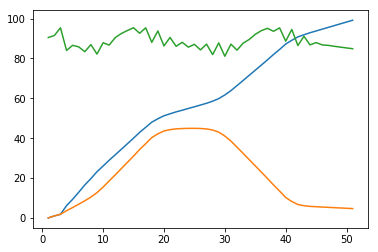

In [820]:
#plt.plot(x_path[:,3],xs[:,3])
plt.plot(xindex,xs[:,0])
plt.plot(xindex,xs[:,1])
plt.plot(xindex,xs[:,2])

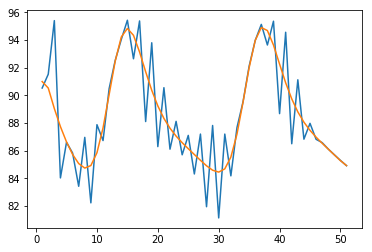

In [821]:
plt.plot(xindex,xs[:,2])
plt.plot(xindex,x_path[:,2])

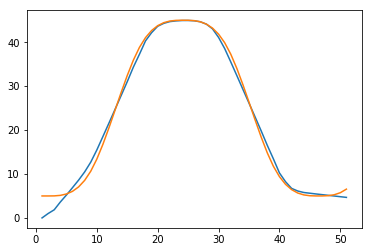

In [822]:
plt.plot(xindex,xs[:,1])
plt.plot(xindex,x_path[:,1])

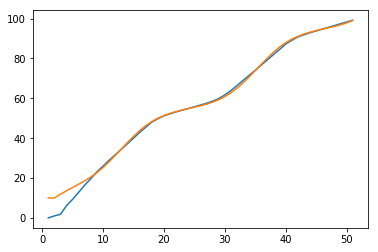

In [823]:
plt.plot(xindex,xs[:,0])
plt.plot(xindex,x_path[:,0])


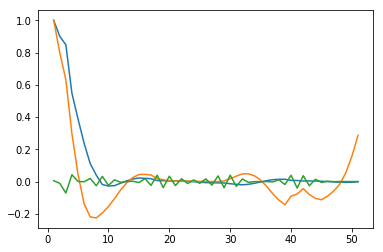

In [824]:
plt.plot(xindex,(x_path[:,0]-xs[:,0])/x_path[:,0])
plt.plot(xindex,(x_path[:,1]-xs[:,1])/x_path[:,1])
plt.plot(xindex,(x_path[:,2]-xs[:,2])/x_path[:,2])

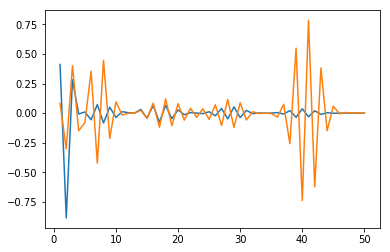

In [825]:
plt.plot(uindex,(u_path[:,0]-us_unconstrained[:,0])/u_path[:,0])
plt.plot(uindex,(u_path[:,1]-us_unconstrained[:,1])/u_path[:,1])
#plt.plot(uindex,(u_path[:,2]-us_unconstrained[:,2])/u_path[:,2])

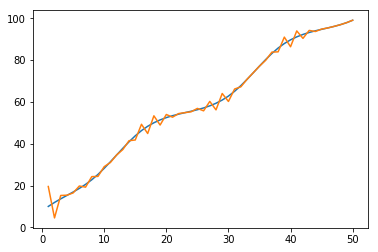

In [831]:
plt.plot(uindex,u_path[:,0])
plt.plot(uindex,us_unconstrained[:,0])


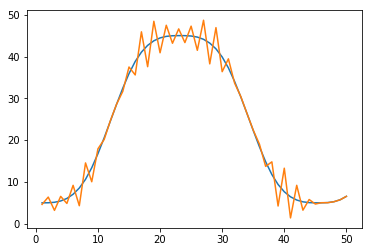

In [834]:
plt.plot(uindex,u_path[:,1])
plt.plot(uindex,us_unconstrained[:,1])